## Beta test functionality for potential object oriented QG system.

#### This notebook / package provides an object oriented version of the 2d QG spectral model: 

available properties of each model:

         Model grid size:
 
        self.N=N
        self.N2=N2
        self.x = np.linspace( 0, 2. * np.pi * Lx, N )
        self.y = np.linspace( 0, 2. * np.pi * Ly, N2 ) #domain size
        self.ll = np.fft.fftfreq( N, Ly / float(N2) )
        self.kk = np.fft.rfftfreq( N2, Lx / float(N) )
        
        self.nu = .01 * (self.x[1] - self.x[0]) ** 4 #viscous dissipation
        self.km = 1. / 5.4 #surface friction, corresponds to 25 days in JH
        self.beta = 0.072 #beta in JH
        self.dt = dt #time step
        self.robert_coefficient = robert_coefficient
        self.U = 1. #Maximum upper level wind speed
        #Running EKE spectrum
        self.ta = 100 #How often to calculate spectra
        self.lim = 1 #when to start calculating spectra
        
        
        #Spectral arrays, only need 3 time-steps
        self.psic_1 = np.zeros( ( ( 3, N2, N // 2 + 1 ) ) ).astype( complex )
        self.psic_2 = np.zeros( ( ( 3, N2, N // 2 + 1  ) ) ).astype( complex )
        self.qc_1 = np.zeros( ( ( 3, N2, N // 2 + 1  ) ) ).astype( complex )
        self.qc_2 = np.zeros( ( ( 3, N2, N // 2 + 1  ) ) ).astype( complex )
        self.f0 = 40.
        self.first_step = True
        self.t=0
        self.count=0
        self.opt=3
        
        #Topography -- Gaussian mountain
        self.h_tm = 0.3 #h_max / H_2 (depth of lower layer)
        self.f0 = 40.
        self.xm = max( self.x )
        self.ym = max( self.y )
        self.h_halfx = self.xm / 4. #E-folding length in x-direction
        self.h_halfy = self.ym / 4. #E-folding length in y-direction
        self.h = self.h_tm * np.exp( -( (self.x[np.newaxis, :] - self.xm / 2.)  / self.h_halfx ) ** 2 - ( ( self.y[:, np.newaxis] - self.ym / 2.) / self.h_halfy ) ** 2 )
        #Background PV
        self.Q_1 = np.zeros( ( self.N2, self.N ) )
        self.Q_1[:, :] = (self.beta + self.U / 2.) * self.y[:, np.newaxis]
        self.Q_2 = (self.beta - self.U / 2.) * self.y[:, np.newaxis] + self.f0 * self.h

        self.Q_1c = np.fft.rfft2( self.Q_1)
        self.Q_2c = np.fft.rfft2( self.Q_2)



    


In [2]:
from QG.io import NetCDFWriter
from QG.model import QG2D_Model
import matplotlib.pyplot as plt
import numpy as np

## Instantiate a QG Model & Time Step It.

This will save every step to a netcdf file

In [43]:
N1 = 64
N2 = 64
dt = 0.005

mod1 = QG2D_Model(N1,N2,dt,topo=True) #instantiates the model
mod2 = QG2D_Model(N1,N2,dt,topo=True) #instantiates the model
mod3 = QG2D_Model(N1,N2,dt,topo=True) #instantiates the model
mod4 = QG2D_Model(N1,N2,dt,topo=True) #instantiates the model
mod5 = QG2D_Model(N1,N2,dt,topo=True) #instantiates the model

mod1.random_init()  #randomly initiates the model.

print('Saving output at time: {}'.format(mod1.t))
mod1.integrate()
ModSaver = NetCDFWriter(mod1, 'New_Initiialize.nc')

# #how many time steps to save: 
TS = 2000  #BE CAREFUL THIS SAVES EVERY TIME STEP AND CAN GET BIG FAST.
for ii in range(0,TS):
    mod1.integrate()
    mod2.integrate()
    ModSaver.save()
ModSaver.close()

starting from scratch


## Function to Save 'Snap Shots':

This function allows you to run and save every X steps

In [47]:
N1 = 64
N2 = 64
dt = 0.005

mod1 = QG2D_Model(N1,N2,dt,topo=True)
mod1.random_init()
print('First Step?:',mod1.first_step)
mod1.integrate()
print('First Step?:',mod1.first_step)


starting from scratch
First Step?: True
First Step?: False


In [48]:
N1 = 64
N2 = 64
dt = 0.005
mod1 = QG2D_Model(N1,N2,dt,topo=True)
mod1.random_init()
mod1.lim=1000 #spin up time.

mult1 = 1000 #total run time
mult2 = 100 #output save interval

saver = NetCDFWriter(mod1, 'SaveSnapShots.nc')
second = mod1.dt  #remember dt 
run_time = mult1 * second
output_interval = mult2 * second

#eventually put this in the back end? 
sk = np.zeros( ( ( mult1 // mult2, mod1.N2, mod1.N // 2 + 1) ) )
tak = np.zeros( ( ( mult1 // mult2, mod1.N2, mod1.N // 2 + 1) ) )
tkk = np.zeros( ( ( mult1 // mult2, mod1.N2, mod1.N // 2 + 1) ) )
tak = np.zeros( ( ( mult1 // mult2, mod1.N2, mod1.N // 2 + 1) ) )
fk = np.zeros( ( ( mult1 // mult2, mod1.N2, mod1.N // 2 + 1) ) )
vk = np.zeros( ( ( mult1 // mult2, mod1.N2, mod1.N // 2 + 1) ) )
ek = np.zeros( ( ( mult1 // mult2, mod1.N2, mod1.N // 2 + 1) ) )

print('spin up model')
for ii in range(0,mod1.lim):
    mod1.integrate()
print('..spun up.. ..saving in steps..')

print(mod1.t)
mod1.t=0 #this is hacky... fix it ... maybe use 'self.random_init()' to spin up the model too, then reset. 

# The run_with_snapshots method is an iterator that yields the
# current model time at the given interval. This means we can
# loop over the iterator saving the current model state.
for ii,t in enumerate(mod1.run_with_snapshots(run_time, snapshot_interval=output_interval)):
    print('Saving output at time: {}'.format(mod1.count))
    mod1.calc_energy_budget()
    ek[ii]=mod1.ek
    tak[ii]=mod1.tak
    fk[ii]=mod1.fk
    tkk[ii]=mod1.tkk
    vk[ii]=mod1.vk
    sk[ii]=mod1.sk
    saver.save()
saver.close()

starting from scratch
spin up model
..spun up.. ..saving in steps..
4.999999999999916
1000
Saving output at time: 1100
Saving output at time: 1200
Saving output at time: 1300
Saving output at time: 1400
Saving output at time: 1500
Saving output at time: 1600
Saving output at time: 1700
Saving output at time: 1800
Saving output at time: 1900
Saving output at time: 2000


## Plot Current PV Values:

In [31]:
#how many time steps to save: 
mod1 = QG2D_Model(N1,N2,dt,Lx,Ly,topo=True)
mod1.random_init()
TS = 40000  #integrate without saving. 
for ii in range(0,TS):
    mod1.integrate()
    mod1.calc_energy_budget()


starting from scratch


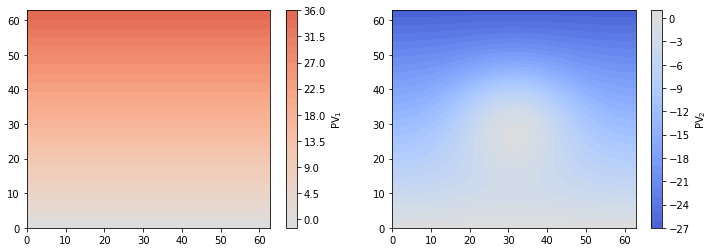

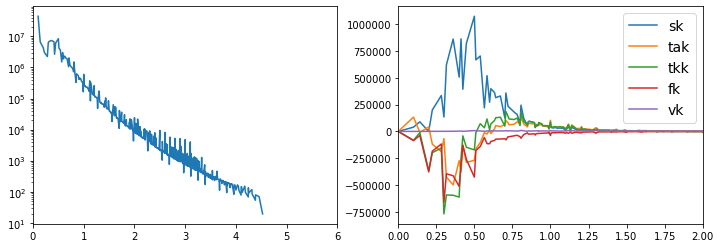

In [49]:
pv1,pv2 = mod1.q_sp2re()
plt.figure(figsize=(12,4))
ax = plt.subplot(1, 2, 1)
plt.contourf(mod1.x, mod1.y, pv1,30,cmap = plt.cm.coolwarm, vmin=-50,vmax=50)
cs = plt.colorbar()
cs.set_label("PV$_1$")

ax = plt.subplot(1, 2, 2)
plt.contourf(mod1.x, mod1.y, pv2,30,cmap = plt.cm.coolwarm, vmin=-30,vmax=30)
cs = plt.colorbar()
cs.set_label("PV$_2$")

plt.show()

plt.figure(figsize=(12,4))
ax = plt.subplot(1, 2, 1)
plt.semilogy(nKs[1:], nek[1:] )
plt.xlim([0,6])

plt.subplot(1, 2, 2)
plt.plot( nKs, nsk )
plt.plot(  nKs, ntak)
plt.plot(  nKs, ntkk)
plt.plot(  nKs, nfk )
plt.plot(  nKs, nvk)
plt.xlim([0,2])
plt.legend(["sk", "tak", "tkk", "fk", "vk"], loc = "upper right",fontsize=14)
plt.show()

In [41]:
ek = np.mean(ek, axis = 0)
ek = np.reshape(ek, (mod1.N2 * (mod1.N//2 + 1) ))

sk = np.mean(sk, axis = 0)
sk = np.reshape(sk, (mod1.N2 * (mod1.N//2 + 1) ))

tak = np.mean(tak, axis = 0)
tak = np.reshape(tak, (mod1.N2 * (mod1.N//2 + 1) ))

tkk = np.mean(tkk, axis = 0)
tkk = np.reshape(tkk, (mod1.N2 * (mod1.N//2 + 1) ))

fk = np.mean(fk, axis = 0)
fk = np.reshape(fk, (mod1.N2 * (mod1.N//2 + 1) ))

vk = np.mean(vk, axis = 0)
vk = np.reshape(vk, (mod1.N2 * (mod1.N//2 + 1) ))

Ks = np.reshape( mod1.Ks, (mod1.N2 * (mod1.N//2 + 1) ))
inds = Ks.argsort()
Ks.sort()
ek = ek[inds] 
sk = sk[inds] 
tak = tak[inds] 
tkk = tkk[inds] 
fk = fk[inds] 
vk = vk[inds] 

#Sum over duplicates. There must be a better way...
nKs = np.unique( Ks )
nek = np.zeros( len(nKs) )
nsk = np.zeros( len(nKs) )
ntak = np.zeros( len(nKs) )
ntkk = np.zeros( len(nKs) )
nfk = np.zeros( len(nKs) )
nvk = np.zeros( len(nKs) )
for i in range( len(nKs) ):
    nek[i] = sum(ek[np.where( Ks == nKs[i])])
    nsk[i] = sum(sk[np.where( Ks == nKs[i])])
    ntak[i] = sum(tak[np.where( Ks == nKs[i])])
    ntkk[i] = sum(tkk[np.where( Ks == nKs[i])])
    nfk[i] = sum(fk[np.where( Ks == nKs[i])])
    nvk[i] = sum(vk[np.where( Ks == nKs[i])])